In [ ]:
import pandas as pd
import os
import h5py
import re
import json
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from datetime import time, timedelta

from chifolio.measure import create_return_risk_metrics
from chifolio.backtest import Backtest
from scipy import stats
from collections import OrderedDict

# 读取数据

## 读取chifolio包

In [ ]:
with open("chifolio_lib\\MONTH_END.json", "r", encoding="utf-8") as f:
    MONTH_END = json.load(f)  
with open("chifolio_lib\\WEEK_END.json", "r", encoding="utf-8") as f:
    WEEK_END = json.load(f)  
MONTH_END = pd.to_datetime(MONTH_END)
WEEK_END = pd.to_datetime(WEEK_END)

def cal_ic(descriptor, price, date_list,method='spearman', block=None):
    """计算IC
    """

    date_range = descriptor.index.levels[0]
    start, end = date_range.min(), date_range.max()

    week_rets = price.reindex(date_list).pct_change()
    forward_rets = week_rets.shift(-1)

    ic = OrderedDict()

    for dt in date_list:

        dtstr = dt.strftime('%Y%m%d')

        if block is not None:

            if dt < pd.to_datetime(start):
                continue
            if dt > pd.to_datetime(end):
                continue

            universe = block.get(dt)
            if universe is None:
                continue

            if descriptor.get(dtstr) is None:
                continue

            if len(descriptor.get(dtstr).dropna())<10:
                continue

            des = descriptor.get(dtstr).squeeze().reindex(universe) if descriptor.get(
                dtstr) is not None else descriptor.get(dtstr)
            ret = forward_rets.loc[dtstr].squeeze().reindex(universe)

        else:
            des = descriptor.get(dtstr)
            ret = forward_rets.loc[dtstr]

        if (des is None) or (ret.empty):
            continue

        ic[dt] = des.corr(ret.squeeze(), method=method)

    res = pd.Series(ic).dropna()

    return res

def ic_statistic(ic):
    res = pd.Series({'IC': ic.mean(), 'ICSTD': ic.std(), 
                     'IR': ic.mean()/ic.std(), 
                     'T': stats.ttest_1samp(ic.dropna(),0).statistic})
    return res

## 价格数据

In [ ]:
def load_group(group):
    out = {}
    for key in group.keys():
        # 如果 key 不是 str 类型，将其转换为字符串
        key_str = key if isinstance(key, str) else '_'.join(map(str, key))
        item = group[key]
        # 如果是一个数据集，则直接读取数据；如果是 group，则递归读取
        if isinstance(item, h5py.Dataset):
            out[key_str] = item[()]
        elif isinstance(item, h5py.Group):
            out[key_str] = load_group(item)
        else:
            out[key_str] = None
    return out

def load_h5(file_path):
    with h5py.File(file_path, 'r') as f:
        return load_group(f)

def convert_h5_dict_to_df(h5_dict):
    data = h5_dict['data']
    index = pd.to_datetime(data['axis1'])  # 行索引：时间戳
    columns = [x.decode('utf-8') if isinstance(x, bytes) else x for x in data['block0_items']]  # 列名：股票代码
    values = data['block0_values']  # 二维数组
    df = pd.DataFrame(values, index=index, columns=columns)
    return df

price_path = 'price_daily.h5'
raw_data = load_h5(price_path)
df_price = convert_h5_dict_to_df(raw_data)

# 筛选2021的全A价格数据
start_date = '2013-12-30'
end_date = '2023-01-06'
df_price_filtered = df_price.loc[start_date:end_date]

## 计算ewa_mean_1422

In [ ]:
df_scores = pd.read_parqeut("df_scores_newsts_1422.parquet")

In [ ]:
df_agg = df_scores.groupby(['stockcode', 'date'])['ds_score'].agg(
    ds_score_sum='sum',
    ds_score_mean='mean'
).sort_values(by=['date', 'stockcode']).reset_index()

descriptor = df_agg.copy()
descriptor.rename(columns={'stockcode':'asset'}, inplace=True)
descriptor.set_index(['date','asset'],inplace=True)
descriptor = descriptor.sort_index()

In [ ]:
def generate_ewa_weights(window, span):
    alpha = 2 / (span + 1)
    weights = [(1 - alpha) ** (window - i - 1) for i in range(window)]
    weights = np.array(weights)
    weights /= weights.sum()  # 归一化
    return weights

weights_list_7 = generate_ewa_weights(window=7, span=3)

In [ ]:
weights_list_7

array([0.00787402, 0.01574803, 0.03149606, 0.06299213, 0.12598425,
       0.2519685 , 0.50393701])

In [ ]:
def calculate_ewa_with_fixed_weights(descriptor, window, weights, value_column):
    descriptor_df = descriptor.copy()
    descriptor_df = descriptor_df.sort_index()  # 注意是 sort_index，因为你已经是 MultiIndex
    descriptor_df = descriptor_df.reset_index()  # 把 date, asset 还原成列！

    pivot_df = descriptor_df.pivot(index='date', columns='asset', values=value_column)
    
    def weighted_sum(x):
        if (x == 0).all():
            return np.nan
        return np.sum(x.values * weights)
    
    pivot_df.fillna(0, inplace=True) 
    rolling_result = pivot_df.rolling(window=window, min_periods=window).apply(weighted_sum, raw=False)
    
    ewa_df = rolling_result.stack().to_frame(name=f'{value_column}_ewa')

    return ewa_df

# 输入准备
window = 7
weights = weights_list_7 
value_column = 'ds_score_mean'
# 调用
ewa_mean_1422 = calculate_ewa_with_fixed_weights(descriptor, window, weights, value_column)


In [ ]:
ewa_mean_1422

ds_score_mean_ewa
date       asset                       
2014-01-08 000001.SZ           0.268766
           000002.SZ           0.107454
           000009.SZ          -0.003150
           000010.SZ           0.011024
           000016.SZ           0.001575
...                                 ...
2023-01-01 900940.SH           0.007874
           900945.SH           0.006299
           900947.SH           0.022047
           900948.SH           0.006299
           900952.SH          -0.050394

[3383682 rows x 1 columns]

## IC 测试

In [ ]:
def cal_ic_v2(descriptor, price, days=5, method='spearman', block=None):
    """计算IC
    descriptor, price,都是日频的
    删除date_list（因为与price index一样没必要筛选）
    加一个参数计算未来n天的收益率
    """

    date_range = descriptor.index.levels[0]
    start, end = date_range.min(), date_range.max()
    date_list = pd.Index(date_range).intersection(df_price.index) # 筛选因子和交易日并集，用于for循环
    # week_rets = price.reindex(date_list).pct_change()
    # forward_rets = week_rets.shift(-1)
    forward_rets = price.pct_change(periods=days).shift(-days)

    ic = OrderedDict()

    for dt in date_list:

        dtstr = dt.strftime('%Y%m%d')

        if block is not None:

            if dt < pd.to_datetime(start):
                continue
            if dt > pd.to_datetime(end):
                continue

            universe = block.get(dt)
            if universe is None:
                continue

            if descriptor.get(dtstr) is None:
                continue

            if len(descriptor.get(dtstr).dropna())<10:
                continue

            # print(f"[DEBUG] 当前日期: {dtstr}")
            # print(descriptor.get(dtstr).index.duplicated().sum())
            # print(descriptor.get(dtstr).index)
            des = descriptor.get(dtstr).squeeze().reindex(universe) if descriptor.get(
                dtstr) is not None else descriptor.get(dtstr)
            ret = forward_rets.loc[dtstr].squeeze().reindex(universe)

        else:
            des = descriptor.get(dtstr)
            ret = forward_rets.loc[dtstr]
            # print(dtstr)
            # print(des)

        if (des is None) or (ret.empty):
            continue

        ic[dt] = des.corr(ret.squeeze(), method=method)

    res = pd.Series(ic).dropna()

    return res


def draw_ic (descriptor,f,days,block,block_name):
    ic_series = cal_ic_v2(descriptor[f], df_price, days=days, block=block)
    print(ic_statistic(ic_series))

    # 计算累计 IC（简单累加）
    cum_ic = ic_series.cumsum()

    # 创建图形和主坐标轴
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # IC 柱状图
    # ax1.bar(range(len(ic_series)), ic_series, color='skyblue', label='Daily IC')
    ax1.bar(ic_series.index, ic_series, color='skyblue', label='Daily IC')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('IC')
    ax1.set_title(f'IC of {f} for future {days} days returns ({block_name})')

    # 创建副坐标轴
    ax2 = ax1.twinx()
    # ax2.plot(range(len(cum_ic)), cum_ic, color='red', label='Cumulative IC', linewidth=2)
    ax2.plot(cum_ic.index, cum_ic, color='red', label='Cumulative IC', linewidth=2)
    ax2.set_ylabel('Cumulative IC')

    # 合并图例
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.tight_layout()
    plt.grid(True)
    plt.show()

IC       0.007368
ICSTD    0.064731
IR       0.113828
T        5.324429
dtype: float64


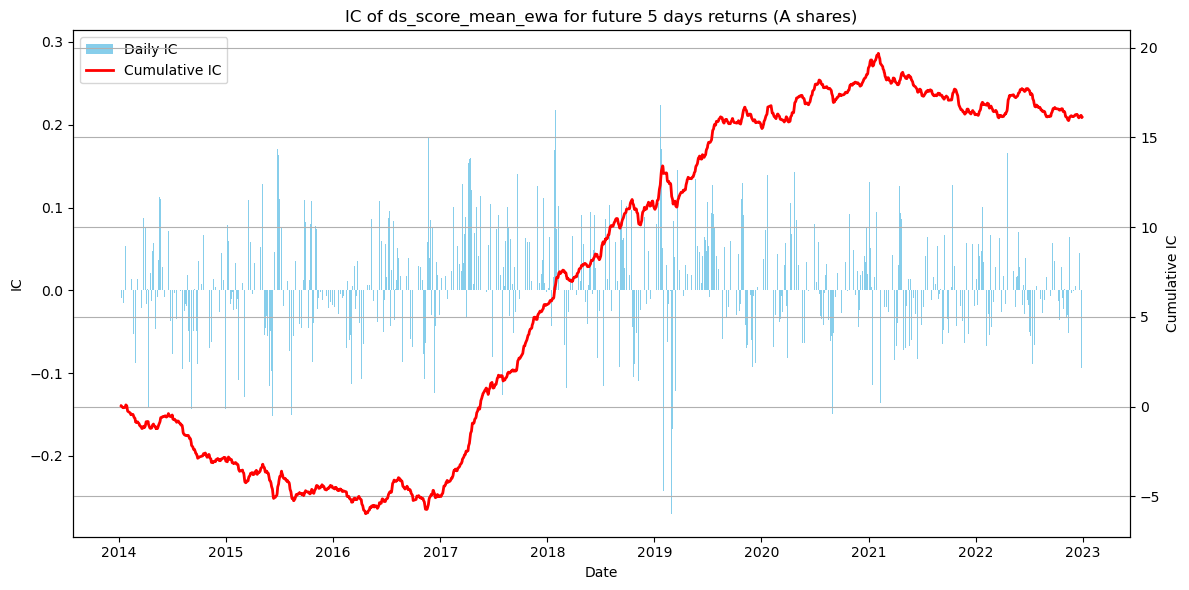

In [ ]:
f = 'ds_score_mean_ewa'
days=5
block = None
block_name = 'A shares'
draw_ic(ewa_mean_1422,f,days,block,block_name) 

c:\Users\26954\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4878: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



IC        0.016756
ICSTD     0.062337
IR        0.268801
T        12.570601
dtype: float64


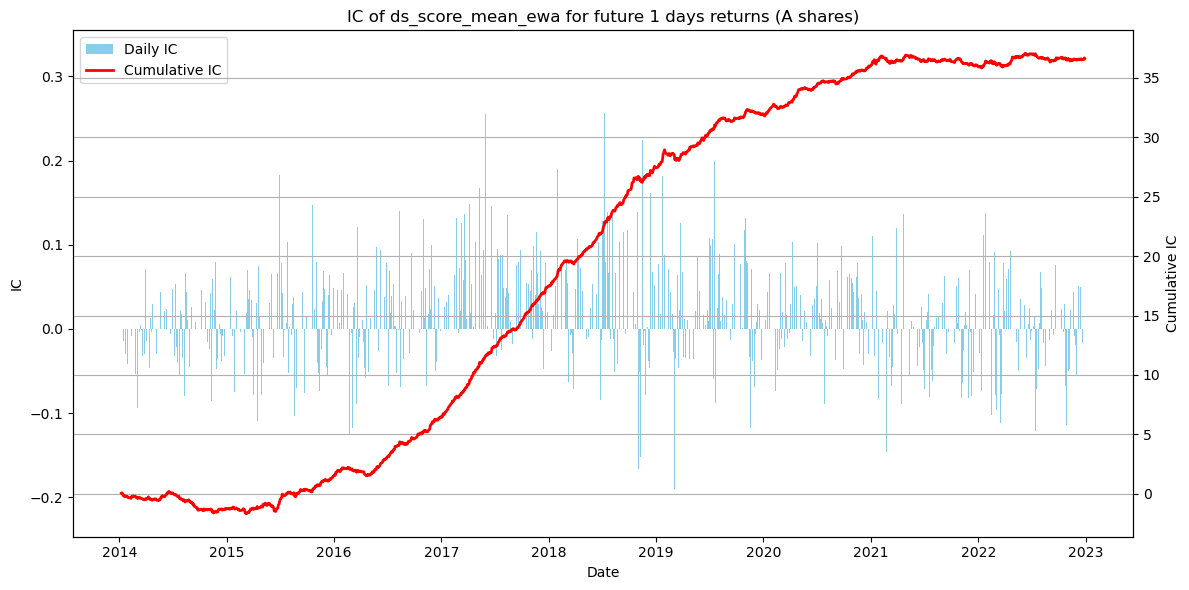

In [ ]:
f = 'ds_score_mean_ewa'
days=1
block = None
block_name = 'A shares'
draw_ic(ewa_mean_1422,f,days,block,block_name) 

## 回测

2017-02-03 00:00:00 失败：Bin edges must be unique: array([-0.35275591, -0.1511811 , -0.02015748,  0.04535433,  0.1511811 ,
        0.17637795,  0.2519685 ,  0.2519685 ,  0.2519685 ,  0.35275591,
        0.47874016]).
You can drop duplicate edges by setting the 'duplicates' kwarg
2018-02-23 00:00:00 失败：Bin edges must be unique: array([-0.50393701, -0.13349606, -0.01259843,  0.07480315,  0.12598425,
        0.1511811 ,  0.17637795,  0.2519685 ,  0.2519685 ,  0.35275591,
        0.52913386]).
You can drop duplicate edges by setting the 'duplicates' kwarg


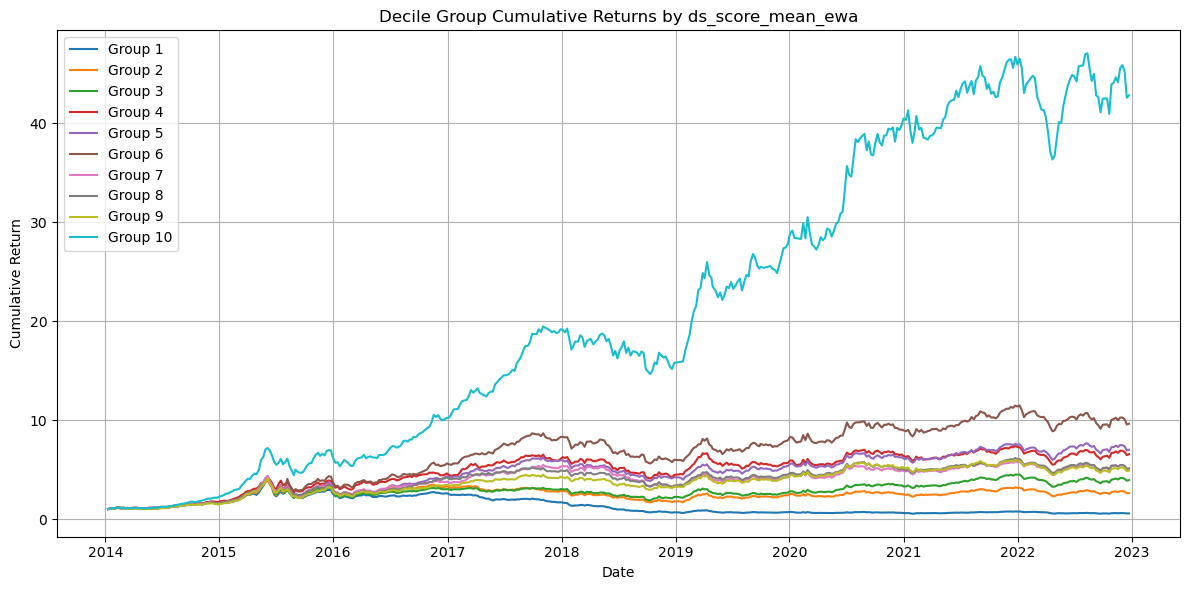

In [ ]:
# 初始化
factor_df = ewa_mean_1422.copy()
quantile_returns = {i: [] for i in range(10)}
rebalance_dates = factor_df.index.levels[0].intersection(WEEK_END)


# 重采样生成月收益率
weekly_returns = df_price.reindex(rebalance_dates).pct_change().shift(-1)

# 遍历每个调仓日
for date in rebalance_dates[:-1]:
    try:
        current_factor = factor_df.loc[date, 'ds_score_mean_ewa']
        valid_data = current_factor.loc[current_factor.index.intersection(weekly_returns.columns)]

        # 分成10组
        deciles = pd.qcut(valid_data, q=10, labels=False)
        for i in range(10):
            group_stocks = deciles[deciles == i].index
            group_return = weekly_returns.loc[date, group_stocks].mean()
            quantile_returns[i].append(group_return)
    except Exception as e:
        print(f"{date} 失败：{e}")
        for i in range(10):
            quantile_returns[i].append(None)

# 转为 DataFrame，行为时间，列为分组
quantile_return_df = pd.DataFrame(quantile_returns, index=rebalance_dates[:-1])

# 累计净值
quantile_cumret_df = (1 + quantile_return_df.fillna(0)).cumprod()

# 画图
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(quantile_cumret_df.index, quantile_cumret_df[i], label=f'Group {i+1}')
plt.title('Decile Group Cumulative Returns by ds_score_mean_ewa')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

2017-02-03 00:00:00 回测失败: Bin edges must be unique: array([-0.35275591, -0.1511811 , -0.01007874,  0.10582677,  0.1511811 ,
        0.21417323,  0.2519685 ,  0.2519685 ,  0.2696063 ,  0.35275591,
        0.47874016]).
You can drop duplicate edges by setting the 'duplicates' kwarg
2018-02-23 00:00:00 回测失败: Bin edges must be unique: array([-0.50393701, -0.12473701, -0.01259843,  0.06740157,  0.12598425,
        0.1511811 ,  0.17637795,  0.2519685 ,  0.2519685 ,  0.35275591,
        0.52913386]).
You can drop duplicate edges by setting the 'duplicates' kwarg


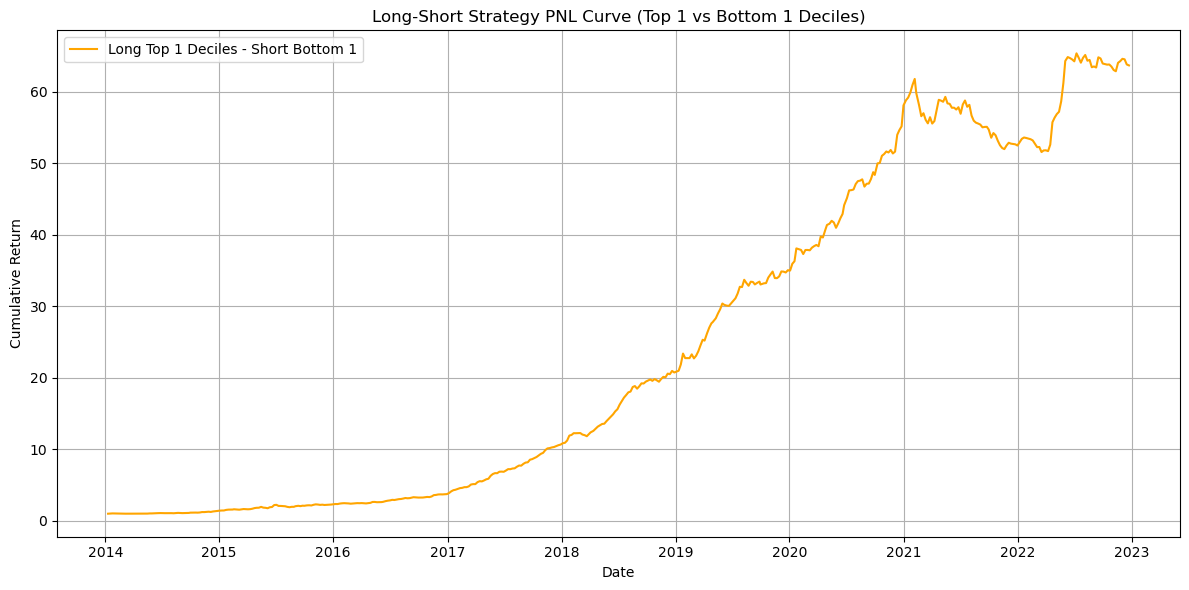

Annual Return         0.6027
Annual Volatility     0.1434
Information Ratio     4.2041
Max Drawdown         10.2299
Win Rate              0.6681
dtype: float64


In [ ]:
factor_df = ewa_mean_1422.copy()
# common_stocks = factor_df.index.get_level_values(1).intersection(df_price.columns)
# factor_df = factor_df[factor_df.index.get_level_values(1).isin(common_stocks)]
valid_price_locs = df_price_filtered.stack().dropna().index  # MultiIndex: (date, asset)
factor_df = factor_df.loc[factor_df.index.intersection(valid_price_locs)]
rebalance_dates = factor_df.index.levels[0].intersection(WEEK_END)
common_stocks = factor_df.index.get_level_values(1).unique()

# 生成周度收益率：用每周最后一个交易日价格计算下周涨跌幅
weekly_returns = df_price_filtered[common_stocks].reindex(rebalance_dates).pct_change().shift(-1)

# 初始化空的收益序列
portfolio_returns = pd.Series(index=rebalance_dates[:-1], name='LongShort_Return', dtype=float)

# 回测：每期做多top1组，做空bottom1组
for date in rebalance_dates[:-1]:
    try:
        current_factor = factor_df.loc[date, 'ds_score_mean_ewa']
        valid_data = current_factor.loc[current_factor.index.intersection(weekly_returns.columns)]

        # 分为10组
        deciles = pd.qcut(valid_data, q=10, labels=False)

        # 做多第9组和第10组（label是8和9），做空第1和第2组（label是0和1）
        long_stocks = deciles[deciles.isin([9])].index
        short_stocks = deciles[deciles.isin([0])].index

        # 对应收益
        long_ret = weekly_returns.loc[date, long_stocks].mean()
        short_ret = weekly_returns.loc[date, short_stocks].mean()

        # 多空组合收益
        portfolio_returns.loc[date] = long_ret - short_ret
    except Exception as e:
        print(f"{date} 回测失败: {e}")
        continue

# 计算累计净值
cum_ret = (1 + portfolio_returns.dropna()).cumprod()

# 📈 绘制 PNL 曲线
plt.figure(figsize=(12, 6))
plt.plot(cum_ret.index, cum_ret.values, label='Long Top 1 Deciles - Short Bottom 1', color='orange')
plt.title('Long-Short Strategy PNL Curve (Top 1 vs Bottom 1 Deciles)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 📊 计算绩效指标
def compute_metrics(returns):
    ann_ret = (1 + returns).prod() ** (52 / len(returns)) - 1
    ann_vol = returns.std() * np.sqrt(52)
    ir = ann_ret / ann_vol if ann_vol != 0 else np.nan
    max_dd = ((1 + returns).cumprod().cummax() - (1 + returns).cumprod()).max()
    win_rate = (returns > 0).mean()
    return pd.Series({
        'Annual Return': ann_ret,
        'Annual Volatility': ann_vol,
        'Information Ratio': ir,
        'Max Drawdown': max_dd,
        'Win Rate': win_rate
    })

perf = compute_metrics(portfolio_returns.dropna())
print(perf.round(4))


2017-02-03 00:00:00 回测失败: Bin edges must be unique: array([-0.35275591, -0.1511811 , -0.01007874,  0.10582677,  0.1511811 ,
        0.21417323,  0.2519685 ,  0.2519685 ,  0.2696063 ,  0.35275591,
        0.47874016]).
You can drop duplicate edges by setting the 'duplicates' kwarg
2018-02-23 00:00:00 回测失败: Bin edges must be unique: array([-0.50393701, -0.12473701, -0.01259843,  0.06740157,  0.12598425,
        0.1511811 ,  0.17637795,  0.2519685 ,  0.2519685 ,  0.35275591,
        0.52913386]).
You can drop duplicate edges by setting the 'duplicates' kwarg


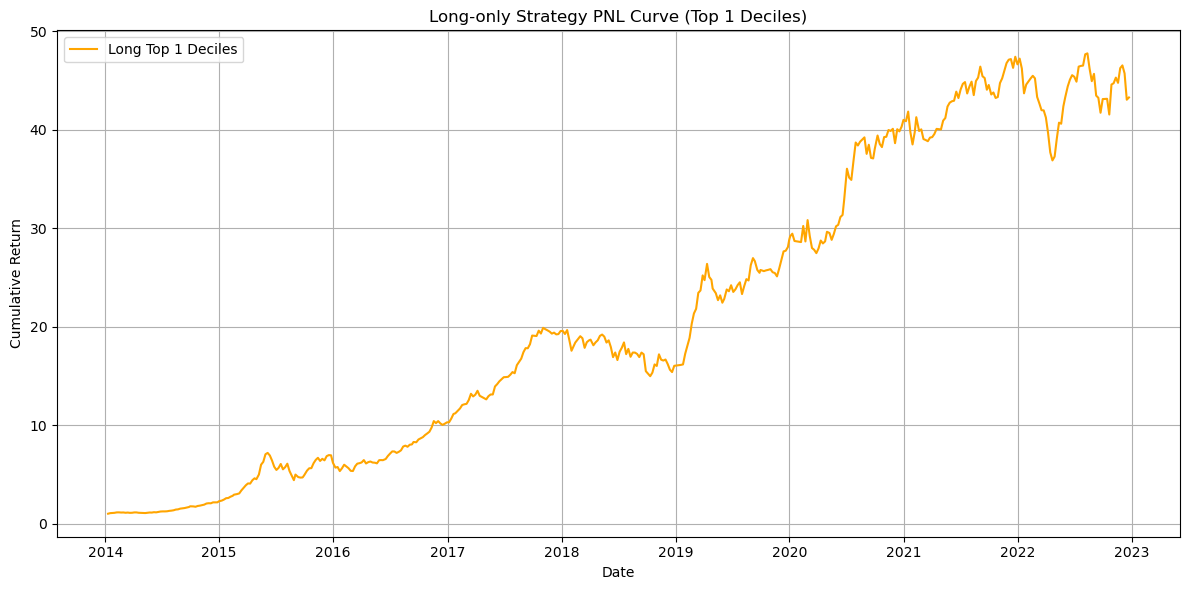

Annual Return         0.5339
Annual Volatility     0.2578
Information Ratio     2.0709
Max Drawdown         10.5318
Win Rate              0.6310
dtype: float64


In [ ]:
# 提取可用数据的交集
factor_df = ewa_mean_1422.copy()
# common_stocks = factor_df.index.get_level_values(1).intersection(df_price.columns)
# factor_df = factor_df[factor_df.index.get_level_values(1).isin(common_stocks)]
valid_price_locs = df_price_filtered.stack().dropna().index  # MultiIndex: (date, asset)
factor_df = factor_df.loc[factor_df.index.intersection(valid_price_locs)]
rebalance_dates = factor_df.index.levels[0].intersection(WEEK_END)
common_stocks = factor_df.index.get_level_values(1).unique()

# 生成周度收益率：用每周最后一个交易日价格计算下周涨跌幅
weekly_returns = df_price_filtered[common_stocks].reindex(rebalance_dates).pct_change().shift(-1)

# 初始化空的收益序列
portfolio_returns = pd.Series(index=rebalance_dates[:-1], name='LongShort_Return', dtype=float)
portfolio_pre = {}

# 回测：每期做多top1组，做空bottom1组ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss
for date in rebalance_dates[:-1]:
    try:
        current_factor = factor_df.loc[date, 'ds_score_mean_ewa']
        valid_data = current_factor.loc[current_factor.index.intersection(weekly_returns.columns)]

        # 分为10组
        deciles = pd.qcut(valid_data, q=10, labels=False)

        # 做多第9组和第10组（label是8和9），做空第1和第2组（label是0和1）
        long_stocks = deciles[deciles.isin([9])].index
        # short_stocks = deciles[deciles.isin([0])].index
        
        num_stocks = len(long_stocks)
        if num_stocks >= 1:
            weights = pd.Series(1 / num_stocks, index=long_stocks)
            weights.index.name = 'asset'
            weights.name = 'weight'
            portfolio_pre[date] = weights

        # 对应收益
        long_ret = weekly_returns.loc[date, long_stocks].mean()
        # short_ret = weekly_returns.loc[date, short_stocks].mean()

        # 多空组合收益
        portfolio_returns.loc[date] = long_ret
    except Exception as e:
        print(f"{date} 回测失败: {e}")
        continue

# 计算累计净值
cum_ret = (1 + portfolio_returns.dropna()).cumprod()

# 📈 绘制 PNL 曲线
plt.figure(figsize=(12, 6))
plt.plot(cum_ret.index, cum_ret.values, label='Long Top 1 Deciles', color='orange')
plt.title('Long-only Strategy PNL Curve (Top 1 Deciles)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 📊 计算绩效指标
def compute_metrics(returns):
    ann_ret = (1 + returns).prod() ** (52 / len(returns)) - 1
    ann_vol = returns.std() * np.sqrt(52)
    ir = ann_ret / ann_vol if ann_vol != 0 else np.nan
    max_dd = ((1 + returns).cumprod().cummax() - (1 + returns).cumprod()).max()
    win_rate = (returns > 0).mean()
    return pd.Series({
        'Annual Return': ann_ret,
        'Annual Volatility': ann_vol,
        'Information Ratio': ir,
        'Max Drawdown': max_dd,
        'Win Rate': win_rate
    })

perf = compute_metrics(portfolio_returns.dropna())
print(perf.round(4))


In [ ]:
factor_result = ewa_mean_1422['ds_score_mean_ewa'].copy()
valid_price_locs = df_price_filtered.stack().dropna().index  # MultiIndex: (date, asset)
# 保留在可交易日、可交易资产上的因子值
factor_result = factor_result.loc[factor_result.index.intersection(valid_price_locs)]
factor_result = factor_result.loc[factor_result.index.levels[0].intersection(WEEK_END)]

# 存储等权 portfolio 的结果
portfolio = {}

# 遍历每个月的因子值，取 top 10%
for date, group in factor_result.groupby(level=0):
    try:
        # 去掉缺失值
        valid_group = group.dropna()
        if len(valid_group) < 10:  # 避免样本太小导致 qcut 报错
            continue

        # 分位分组
        quantiles = pd.qcut(valid_group, q=10, labels=False)
        # top10 = quantiles[(quantiles == 9)].index
        top10 = quantiles[quantiles == 9].index.get_level_values(1)
        num_stocks = len(top10)
        weights = pd.Series(1 / num_stocks, index=top10, name='weight')
        weights.index.name = 'asset'
        portfolio[date] = weights
    except Exception as e:
        print(f"{date} 处理失败：{e}")
        continue

In [ ]:
stocks_rets = df_price_filtered.pct_change().fillna(0)
ret_portfolio = Backtest(stocks_rets, portfolio, cost=0.0015).run()

In [ ]:
# 假设ret_portfolio是你的累积收益率Series，索引是日期
# 创建图形
fig = go.Figure()

# 添加累积收益率线
fig.add_trace(
    go.Scatter(
        x=ret_portfolio.index,
        y=ret_portfolio.values,
        mode='lines',
        name='累积收益率',
        line=dict(color='blue', width=2)
    )
)

# 设置图形布局
fig.update_layout(
    title='累积收益率走势图',
    xaxis_title='日期',
    yaxis_title='累积收益率',
    hovermode='x unified',
    
    # 以下设置增强了交互性
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1个月", step="month", stepmode="backward"),
                dict(count=6, label="6个月", step="month", stepmode="backward"),
                dict(count=1, label="1年", step="year", stepmode="backward"),
                dict(count=1, label="全部", step="all")
            ])
        ),
        rangeslider=dict(visible=True),  # 显示范围滑块
        type="date"
    ),
    
    # y轴自动缩放
    yaxis=dict(fixedrange=False)
)

# 显示图形
fig.show()

In [ ]:
create_return_risk_metrics(ret_portfolio.pct_change(), period='daily')

annual_return        35.43%
annual_volatility    25.13%
sharpe_ratio           1.33
max_drawdown         41.92%
omega_ratio           -1.27
calmar_ratio            0.8
sortino_ratio          1.85
dtype: object